# Lesson 4 solutions 2: JIT-compiled Higgs combinatorics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb

import awkward as ak
import vector
from hist import Hist
vector.register_awkward()

In [2]:
events = ak.from_parquet("../data/SMHiggsToZZTo4L.parquet")

<br><br><br>

In [3]:
eplus = events.electron[events.electron.charge > 0]
eminus = events.electron[events.electron.charge < 0]

In [4]:
eplus_event = eplus[448]
eminus_event = eminus[448]

In [5]:
eplus_event.show()

[{pt: 39.4, eta: 0.865, phi: 1.53, mass: 0.00949, charge: 1, ...},
 {pt: 68, eta: 0.681, phi: 0.922, mass: -0.0151, charge: 1, ...},
 {pt: 8.35, eta: -0.359, phi: -1.88, mass: 0.00204, charge: 1, ...}]


In [6]:
eminus_event.show()

[{pt: 9.69, eta: -0.818, phi: -2.42, mass: 0.00165, charge: -1, ...},
 {pt: 53.7, eta: 1.41, phi: 2.29, mass: 0.0105, charge: -1, ...},
 {pt: 57, eta: 0.946, phi: 1.75, mass: 0.0233, charge: -1, ...}]


<br><br><br>

## Solution to exercise 1

In [7]:
print( "e+ index  | e- index ")
print(f"Z1_i Z2_i | Z1_j Z2_j")
print( "----------+----------")
for Z1_i in range(len(eplus_event)):
    for Z2_i in range(Z1_i + 1, len(eplus_event)):
        for Z1_j in range(len(eminus_event)):
            for Z2_j in range(Z1_j + 1, len(eminus_event)):
                print(f"{Z1_i:4d} {Z2_i:4d} | {Z1_j:4d} {Z2_j:4d}")
        print( "----------+----------")

e+ index  | e- index 
Z1_i Z2_i | Z1_j Z2_j
----------+----------
   0    1 |    0    1
   0    1 |    0    2
   0    1 |    1    2
----------+----------
   0    2 |    0    1
   0    2 |    0    2
   0    2 |    1    2
----------+----------
   1    2 |    0    1
   1    2 |    0    2
   1    2 |    1    2
----------+----------


<br><br><br>

## Solution to exercise 2

In [8]:
print( " Zsmall  |  Zbig   ")
print( "---------+---------")
for Z1_i in range(len(eplus_event)):
    for Z2_i in range(Z1_i + 1, len(eplus_event)):
        for Z1_j in range(len(eminus_event)):
            for Z2_j in range(Z1_j + 1, len(eminus_event)):
                Z1 = eplus_event[Z1_i] + eminus_event[Z1_j]
                Z2 = eplus_event[Z2_i] + eminus_event[Z2_j]
                if Z1.mass < Z2.mass:
                    Zsmall, Zbig = Z1, Z2
                else:
                    Zsmall, Zbig = Z2, Z1
                print(f"{Zsmall.mass:.5f} | {Zbig.mass:.5f}")
        print( "---------+---------")

 Zsmall  |  Zbig   
---------+---------
51.54425 | 88.57392
51.54425 | 52.81760
42.52653 | 52.81760
---------+---------
51.54425 | 56.26014
51.54425 | 52.19812
42.52653 | 52.19812
---------+---------
56.26014 | 66.23705
52.19812 | 66.23705
52.19812 | 88.57392
---------+---------


<br><br><br>

## Solution to exercise 3

In [9]:
from particle import Particle
from hepunits import GeV

onshell_mass = Particle.from_name("Z0").mass / GeV

In [10]:
@nb.njit
def best_interpretation(eplus_event, eminus_event):
    best_Zsmall, best_Zbig = None, None
    for Z1_i in range(len(eplus_event)):
        for Z2_i in range(Z1_i + 1, len(eplus_event)):
            for Z1_j in range(len(eminus_event)):
                for Z2_j in range(Z1_j + 1, len(eminus_event)):
                    Z1 = eplus_event[Z1_i] + eminus_event[Z1_j]
                    Z2 = eplus_event[Z2_i] + eminus_event[Z2_j]
                    if Z1.mass < Z2.mass:
                        Zsmall, Zbig = Z1, Z2
                    else:
                        Zsmall, Zbig = Z2, Z1
                    if best_Zbig is None or abs(Zbig.mass - onshell_mass) < abs(best_Zbig.mass - onshell_mass):
                        best_Zsmall, best_Zbig = Zsmall, Zbig
    return best_Zsmall, best_Zbig

best_interpretation(eplus_event, eminus_event)

(MomentumObject4D(pt=33.42538833618164, phi=1.739370346069336, eta=0.799430251121521, mass=51.54425336055015),
 MomentumObject4D(pt=94.71172332763672, phi=1.511854887008667, eta=1.2571223974227905, mass=88.57390122928403))

<br><br><br>

## Solution to exercise 4

In [11]:
@nb.njit
def best_interpretation_per_event(eplus, eminus):
    zmass_small = np.empty(len(eplus), dtype=np.float64)
    zmass_big = np.empty(len(eplus), dtype=np.float64)
    higgsmass = np.empty(len(eplus), dtype=np.float64)
    for i, (eplus_event, eminus_event) in enumerate(zip(eplus, eminus)):
        best_Zsmall, best_Zbig = best_interpretation(eplus_event, eminus_event)
        if best_Zsmall is not None and best_Zbig is not None:
            zmass_small[i] = best_Zsmall.mass
            zmass_big[i] = best_Zbig.mass
            if 12 < best_Zsmall.mass < 120 and 40 < best_Zbig.mass < 120:
                higgsmass[i] = (best_Zsmall + best_Zbig).mass
            else:
                higgsmass[i] = np.nan
        else:
            zmass_small[i] = np.nan
            zmass_big[i] = np.nan
            higgsmass[i] = np.nan
    return zmass_small, zmass_big, higgsmass

zmass_small, zmass_big, higgsmass = best_interpretation_per_event(eplus, eminus)

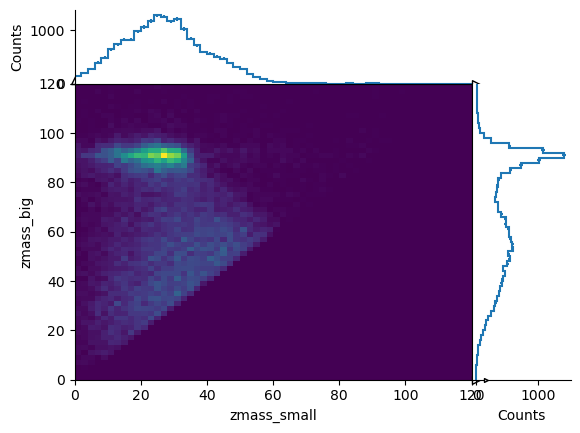

In [12]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=zmass_small,
    zmass_big=zmass_big,
).plot2d_full();

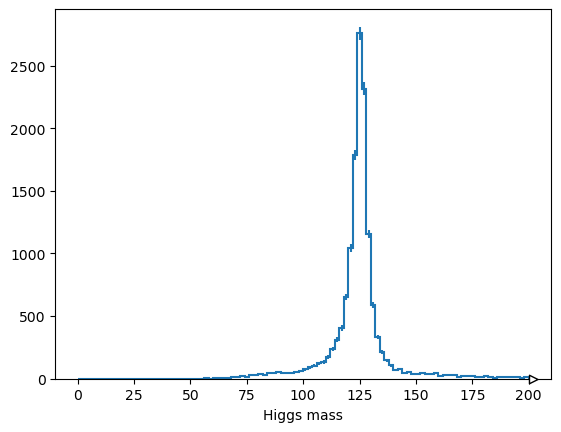

In [13]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    higgsmass
).plot();